## CSVLogger のメトリクスログを解析・ matplotlib でグラフ化

実験2つ:
- 0: `2023-05-27_21:57:38`: $\gamma \in [0, 10)$ で 0.1 刻みずつ.
- 1: `2023-06-06_23:59:43`: $\gamma \in [0, 50)$ で 0.5 刻みずつ.
各$\gamma$ で20回ずつサンプリングした

In [35]:
csv_logdirs = [
    "../log/exp01/gamma_sample_prod/csv/2023-05-27_21:57:38",
    "../log/exp01/gamma_sample_prod/csv/2023-06-06_23:59:43",
]

In [36]:
import glob

csv_logdir = csv_logdirs[1]
hparams_files = glob.glob(f"{csv_logdir}/**/hparams.yaml", recursive=True)
metrics_files = glob.glob(f"{csv_logdir}/**/metrics.csv", recursive=True)

- `hparams.yaml` の中身:
    ```yaml
    lr: 0.01
    n_hid: 100
    n_vis: 784
    normalize_loss: false
    optimizer_name: sgd
    power_law_gamma: 9.5
    ```
- `metrics.csv` の中身: logger に放り込んだ値がごちゃっと入っている

In [37]:
import yaml
import pandas as pd
from pprint import pprint

metrics_dict = dict()

for hparam_path in hparams_files:
    metric_path = hparam_path.replace("hparams.yaml", "metrics.csv")
    hparams = yaml.safe_load(open(hparam_path))
    gamma = hparams["power_law_gamma"]

    df = pd.read_csv(metric_path)
    metrics = df.filter(like="metrics/", axis=1).sum().to_dict()
    for metric, value in metrics.items():
        if not metrics_dict.get(metric):
            metrics_dict[metric] = []

        metrics_dict[metric].append([gamma, value])

metrics_names = sorted(list(metrics_dict.keys()))
for i, m in enumerate(metrics_names):
    print(i, m)

0 metrics/ave_loss_epoch/0
1 metrics/ave_loss_epoch/1
2 metrics/ave_loss_epoch/2
3 metrics/ave_loss_epoch/3
4 metrics/ave_loss_epoch/4
5 metrics/ave_loss_epoch/5
6 metrics/ave_loss_epoch/6
7 metrics/ave_loss_epoch/7
8 metrics/ave_recon_loss_epoch/0
9 metrics/ave_recon_loss_epoch/1
10 metrics/ave_recon_loss_epoch/2
11 metrics/ave_recon_loss_epoch/3
12 metrics/ave_recon_loss_epoch/4
13 metrics/ave_recon_loss_epoch/5
14 metrics/ave_recon_loss_epoch/6
15 metrics/ave_recon_loss_epoch/7


In [38]:
metrics_names[:8]

['metrics/ave_loss_epoch/0',
 'metrics/ave_loss_epoch/1',
 'metrics/ave_loss_epoch/2',
 'metrics/ave_loss_epoch/3',
 'metrics/ave_loss_epoch/4',
 'metrics/ave_loss_epoch/5',
 'metrics/ave_loss_epoch/6',
 'metrics/ave_loss_epoch/7']

In [39]:
metrics_names[8:]

['metrics/ave_recon_loss_epoch/0',
 'metrics/ave_recon_loss_epoch/1',
 'metrics/ave_recon_loss_epoch/2',
 'metrics/ave_recon_loss_epoch/3',
 'metrics/ave_recon_loss_epoch/4',
 'metrics/ave_recon_loss_epoch/5',
 'metrics/ave_recon_loss_epoch/6',
 'metrics/ave_recon_loss_epoch/7']

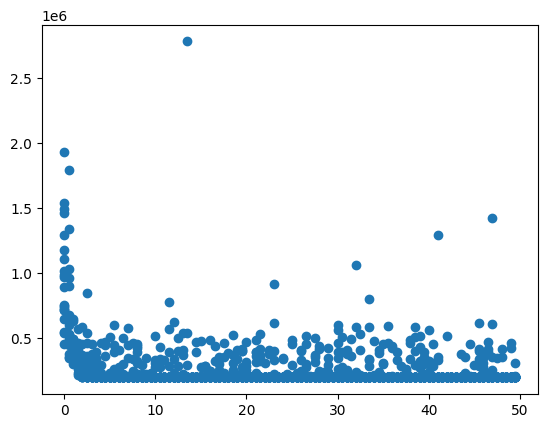

In [40]:
import numpy as np
import matplotlib.pyplot as plt


data = np.array(metrics_dict[metrics_names[15]])  # [gamma, metric] の配列, ただし gamma はソートされていない
plt.scatter(data[:, 0], data[:, 1])

In [41]:
data[:, 1]

array([195778.359375, 195802.015625, 195854.71875 , ..., 195814.078125,
       195820.171875, 195865.53125 ])

In [42]:
from collections import namedtuple

Point = namedtuple("Point", ["gamma", "mean", "err"])


def parse_data(data):
    gamma_mean = (
        pd.DataFrame({"gamma": data[:, 0], "metrics": data[:, 1]})
        .groupby("gamma", as_index=False)
        .mean()
        .sort_values("gamma")
        .to_numpy()
    )
    gamma_err = (
        pd.DataFrame({"gamma": data[:, 0], "metrics": data[:, 1]})
        .groupby("gamma", as_index=False)
        .std()
        .sort_values("gamma")
        .to_numpy()
    )
    return Point(gamma_mean[:, 0], gamma_mean[:, 1], gamma_err[:, 1])


def metrics_to_points(metrics_dict, metrics):
    data = np.array(metrics_dict[metrics])
    return parse_data(data), metrics

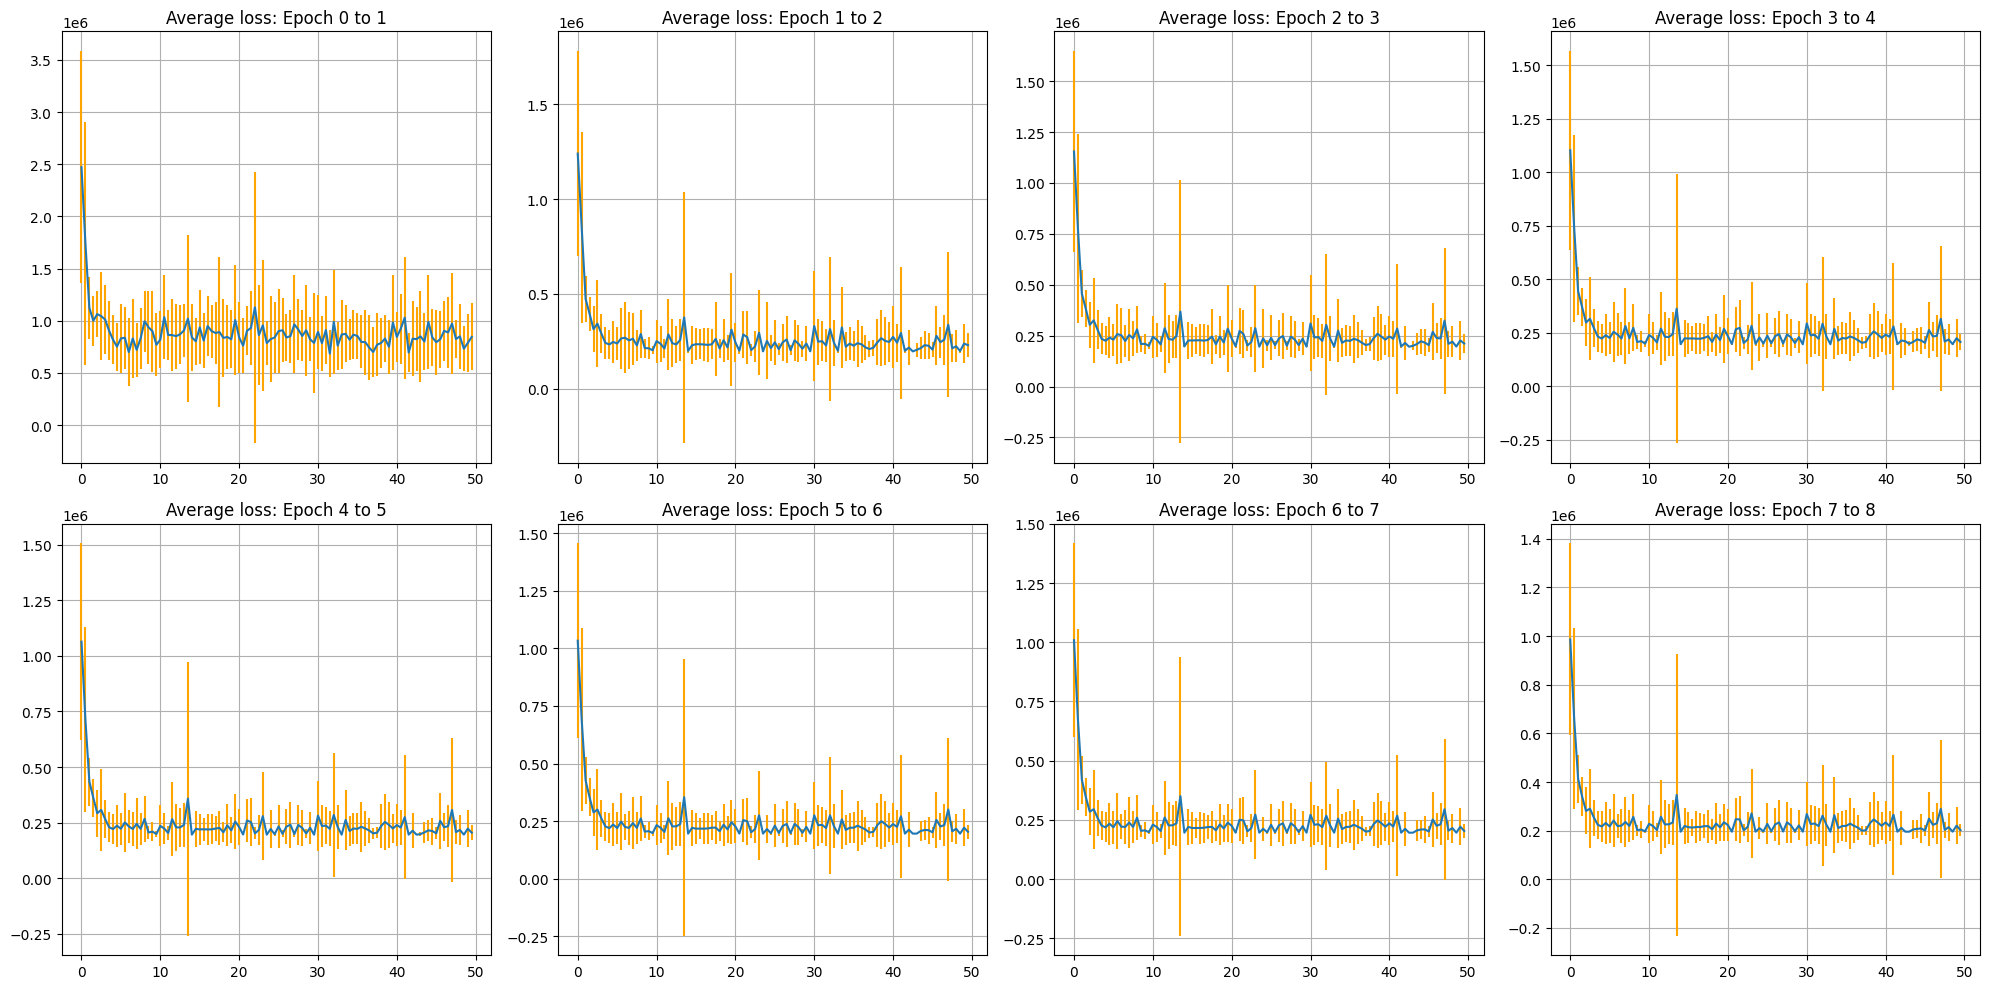

In [43]:
data_list = [metrics_to_points(metrics_dict=metrics_dict, metrics=m) for m in metrics_names]

fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 4行2列のサブプロットを作成し、その配列をaxsに格納します。
label = "Average loss on epoch"
for i, data in enumerate(data_list[:8]):
    value, metric = data
    row = i // 4
    col = i % 4

    _, name, epoch = tuple(metric.split("/"))
    title = f"Average loss: Epoch {epoch} to {int(epoch)+1}"

    axs[row, col].errorbar(value.gamma, value.mean, value.err, ecolor="orange")
    #axs[row, col].plot(value.gamma, value.mean)
    axs[row, col].set_title(title)
    axs[row, col].grid(True)


fig.tight_layout()
plt.show()

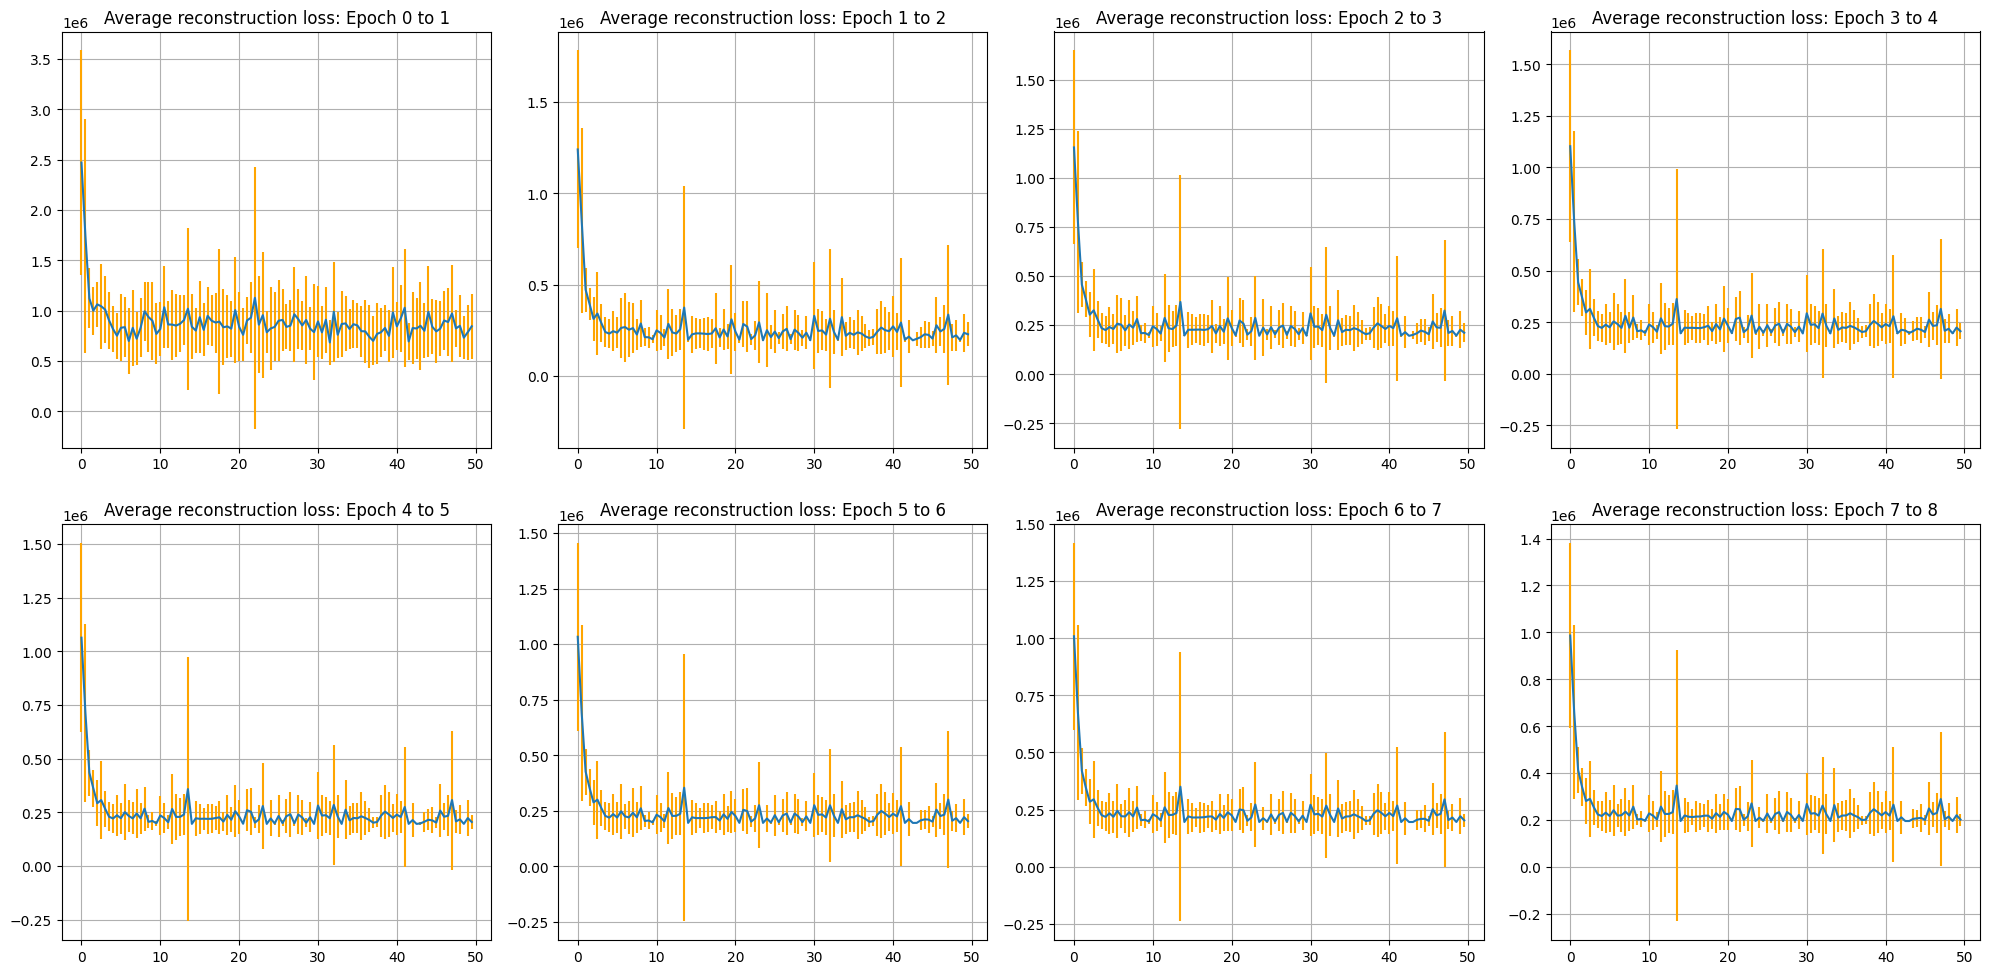

In [44]:
data_list = [metrics_to_points(metrics_dict=metrics_dict, metrics=m) for m in metrics_names]

fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 4行2列のサブプロットを作成し、その配列をaxsに格納します。
label = "Average reconstruction loss on epoch"
for i, data in enumerate(data_list[8:]):
    value, metric = data
    row = i // 4
    col = i % 4

    _, name, epoch = tuple(metric.split("/"))
    title = f"Average reconstruction loss: Epoch {epoch} to {int(epoch)+1}"

    axs[row, col].errorbar(value.gamma, value.mean, value.err, ecolor="orange")
    axs[row, col].set_title(title)
    axs[row, col].grid(True)


fig.tight_layout()
plt.show()

In [45]:
mp = dict()  # キーが gamma, 値が metric のリスト

for point in data:
    x, y = point[0], point[1]
    if mp.get(x) is None:
        mp[x] = []
    mp[x].append(y)

values = []
for x, y_lst in mp.items():
    y_arr = np.array(y_lst)
    y_mean = np.mean(y_arr)
    y_std = np.std(y_arr)
    values.append((x, y_mean, y_std))

values.sort(key=lambda x: x[0])
values = np.array(values)
plt.plot(values[:, 0], values[:, 1])

TypeError: unhashable type: 'numpy.ndarray'

<ErrorbarContainer object of 3 artists>

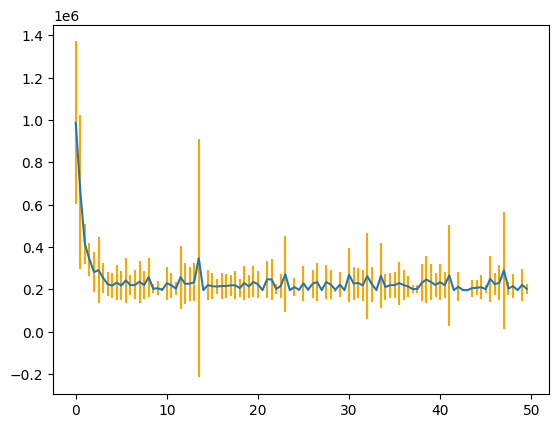

In [ ]:
plt.errorbar(values[:, 0], values[:, 1], values[:, 2], ecolor="orange")

In [ ]:
import glob

csv_logdir = "../log/exp01/gamma_sample_prod/csv/2023-06-06_23:59:43"
hparams_files = glob.glob(f"{csv_logdir}/**/hparams.yaml", recursive=True)
metrics_files = glob.glob(f"{csv_logdir}/**/metrics.csv", recursive=True)

hparams_files

['../log/exp01/gamma_sample_prod/csv/2023-06-06_23:59:43/gamma=41.0_sample=12/version_0/hparams.yaml',
 '../log/exp01/gamma_sample_prod/csv/2023-06-06_23:59:43/gamma=38.0_sample=3/version_0/hparams.yaml',
 '../log/exp01/gamma_sample_prod/csv/2023-06-06_23:59:43/gamma=40.0_sample=13/version_0/hparams.yaml',
 '../log/exp01/gamma_sample_prod/csv/2023-06-06_23:59:43/gamma=43.0_sample=4/version_0/hparams.yaml',
 '../log/exp01/gamma_sample_prod/csv/2023-06-06_23:59:43/gamma=13.0_sample=5/version_0/hparams.yaml',
 '../log/exp01/gamma_sample_prod/csv/2023-06-06_23:59:43/gamma=49.0_sample=16/version_0/hparams.yaml',
 '../log/exp01/gamma_sample_prod/csv/2023-06-06_23:59:43/gamma=38.0_sample=15/version_0/hparams.yaml',
 '../log/exp01/gamma_sample_prod/csv/2023-06-06_23:59:43/gamma=37.0_sample=13/version_0/hparams.yaml',
 '../log/exp01/gamma_sample_prod/csv/2023-06-06_23:59:43/gamma=12.0_sample=1/version_0/hparams.yaml',
 '../log/exp01/gamma_sample_prod/csv/2023-06-06_23:59:43/gamma=31.0_sample=6/

In [ ]:
import yaml
import pandas as pd

metrics_dict = dict()

for hparam_path in hparams_files:
    metric_path = hparam_path.replace("hparams.yaml", "metrics.csv")
    hparams = yaml.safe_load(open(hparam_path))
    gamma = hparams["power_law_gamma"]

    df = pd.read_csv(metric_path)
    metrics = df.filter(like="metrics/", axis=1).sum().to_dict()
    for metric, value in metrics.items():
        if not metrics_dict.get(metric):
            metrics_dict[metric] = []

        metrics_dict[metric].append([gamma, value])

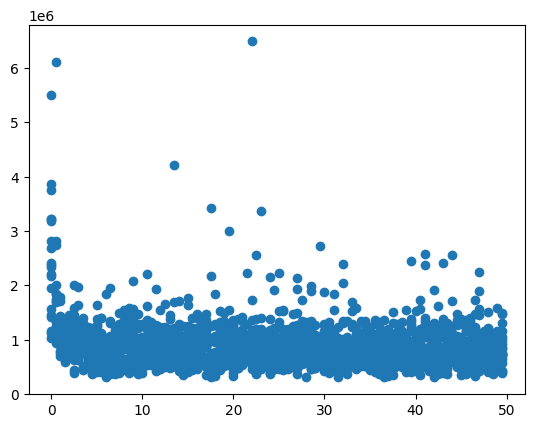

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array(metrics_dict["metrics/ave_loss_epoch/0"])
plt.scatter(data[:, 0], data[:, 1])

<ErrorbarContainer object of 3 artists>

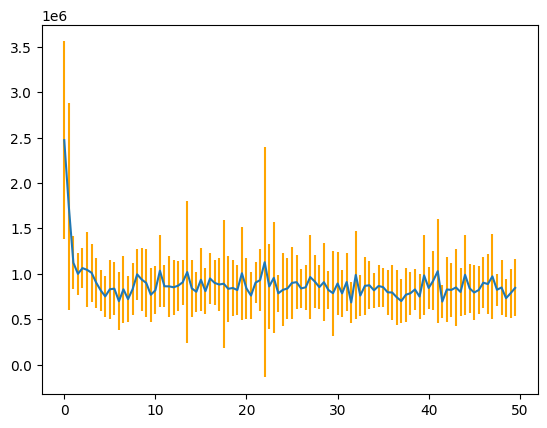

In [ ]:
mp = dict()
for point in data:
    x, y = point[0], point[1]
    if mp.get(x) is None:
        mp[x] = []
    mp[x].append(y)

values = []
for x, y_lst in mp.items():
    y_arr = np.array(y_lst)
    y_mean = np.mean(y_arr)
    y_var = np.var(y_arr)
    values.append((x, y_mean, y_var))

values.sort(key=lambda x: x[0])
values = np.array(values)
plt.errorbar(values[:, 0], values[:, 1], np.sqrt(values[:, 2]), ecolor="orange")